In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense

**Step 1 : Loading Dataset**

In [3]:
df = pd.read_csv(r'C:\Users\nevishwakarma\Documents\Datasets\Data_Udemy\Alcohol_Sales.csv', index_col=['DATE'], parse_dates=True)
df.index.freq = 'MS'
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [7]:
df = df.dropna()
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

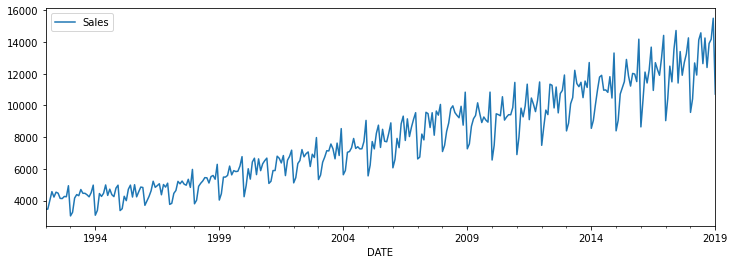

In [9]:
df.plot(figsize=(12,4))

**Step 2 : Check Stationarity**

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
results = seasonal_decompose(df['Sales']);

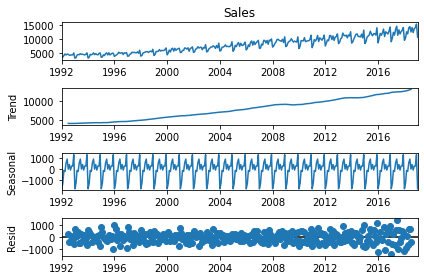

In [14]:
results.plot();

<AxesSubplot:xlabel='DATE'>

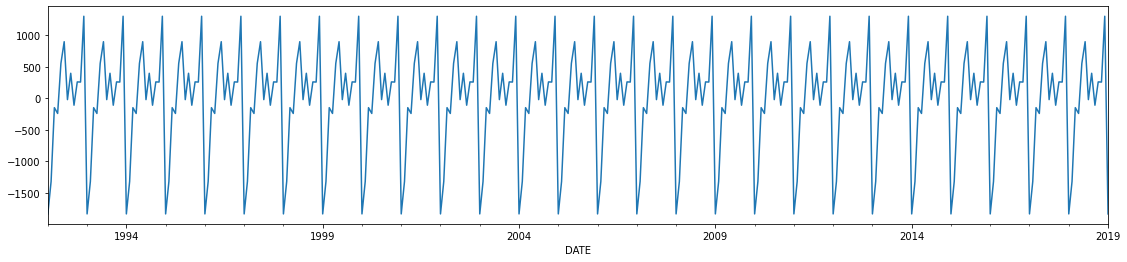

In [17]:
results.seasonal.plot(figsize=(19,4))

We can see that there is definately some sesonality.

**Step 3 : Train Test Split**

In [18]:
len(df)

325

In [19]:
train = df.iloc[:-12]
test = df.iloc[-12:]

**Step 4 : Data Scaling**

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
scaler = MinMaxScaler()

Always while we're scaling the data, we do it for the training data and never the test data. Because if we fit the test data as well, the scaler object would know about the test dataset and that would be a problem.

The <tt>fit</tt> method would do some calculating using the dataset, like getting <tt>standard deviation</tt> and calculate a value and do not do any operation. 

In [27]:
scaler.fit(train) # Find the Max value in the Training Data

MinMaxScaler()

Once we find the value to be used in above step, we divide the dataset (training in this case) with that value.

In [30]:
scaled_train = scaler.transform(train) # Dividing by the Max value
scaled_test = scaler.transform(test)

**Note: Since we used the train data to fit the <tt>scaler</tt> object, there might be some values in the *test dataset* which is greater than the max value of *train dataset*. So we might expect to see some values in <tt>scaled_test</tt> which are greater than 1. This is no problem because the whole point of this exercise is to bring the data to some lower values.**

**Step 5 : Process data for timeseries**

In [31]:
from keras.preprocessing.sequence import TimeseriesGenerator

<tt>n_input</tt> is how much you exactly see before the Y label.

<tt>n_features</tt> is how many columns we have and it is always 1 for a timeseries.

In [36]:
n_input = 3
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [34]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [37]:
generator[0]

(array([[[0.03658432],
         [0.03649885],
         [0.08299855]]]),
 array([[0.13103684]]))

For the series:

$x_t,x_{t+1},x_{t+2}, ... , x_{t+n}$

We have the data for n_inputs = 2 like 

$X = [x_t, x_{t+1}]$

$Y = [x_{t+2}]$

As the basic, if the series has sesonality, the value of n_inputs should ideally be equal to the sesonality.

**Step 6 : Modelling**

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [49]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [50]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.fit_generator(train_generator, epochs=25)

Epoch 1/25
301/301 [==============================] - 1s 4ms/step - loss: 0.0139
Epoch 2/25
301/301 [==============================] - 1s 4ms/step - loss: 0.0088
Epoch 3/25
301/301 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 4/25
301/301 [==============================] - 1s 4ms/step - loss: 0.0074
Epoch 5/25
301/301 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 6/25
301/301 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 7/25
301/301 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 8/25
301/301 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 9/25
301/301 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 10/25
301/301 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 11/25
301/301 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 12/25
301/301 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 13/25
301/301 [====

In [53]:
model.history.history.keys()

dict_keys(['loss'])

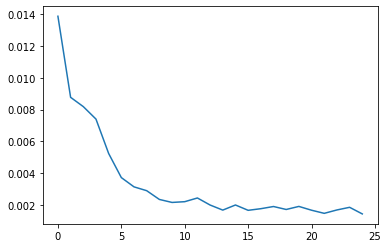

In [54]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

**Step 7 : Prediction for Test data**

Our model right now is like it takes last 12 steps to predict the 13<sup>th</sup> value. So to predict the first value of the test dataset, we need to take the last 12 values fomr the training dataset.

12 history steps -------> step 13 <br/>
last 12 points of train ------> Fist point of test set

In [56]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

This eval batch should beof the dimensions which model accepts, as we've seen above (1,2,1)

In [59]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [67]:
first_pred = model.predict(first_eval_batch)[0]

In [62]:
first_eval_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

Now, let us add the new predicted value in the <tt>first_eval_batch</tt> so we can predict the next value. For that we need to drop the 0<sup>th</sup> value -> 0.63432772 and add the predicted value in 11<sup>th</sup> position.

In [65]:
## This will get rid of the item at 0th Index
first_eval_batch[:,1:,:]

array([[[0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [70]:
# We pass 'first_pred' inside two [[]] as our array, in step above, is having [[]] before the main value arrays. 
# This will add the predicted value att he end of the list of values.
np.append(first_eval_batch[:,1:,:],[[first_pred]], axis=1)

array([[[0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ],
        [0.68083733]]])

Let's now generalize the calculations to get the entire test set.

In [71]:
# holding the predictions
test_predictions = []

# last n_inputs points from the training set
first_eval_batch = scaled_train[-n_input:]

# reshape this to the format RNN wants
current_batch = first_eval_batch.reshape((1,n_input,n_features))

# How far into the future will I forecast?
# len(test) 
for i in range(len(test)):

    # Predict the next point
    current_pred = model.predict(current_batch)[0]    

    # Store the prediction
    test_predictions.append(current_pred)

    # Update the current batch to include the prediction so we can predict the next value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [72]:
test_predictions

[array([0.68083733], dtype=float32),
 array([0.8081042], dtype=float32),
 array([0.75662255], dtype=float32),
 array([0.9148378], dtype=float32),
 array([0.987533], dtype=float32),
 array([0.7437732], dtype=float32),
 array([0.89399755], dtype=float32),
 array([0.76511586], dtype=float32),
 array([0.8406359], dtype=float32),
 array([0.8806177], dtype=float32),
 array([0.95414], dtype=float32),
 array([0.5847378], dtype=float32)]

Invert these pridiction to actual scale.

In [78]:
true_preds = scaler.inverse_transform(test_predictions)
true_preds

array([[10996.11596113],
       [12485.0112353 ],
       [11882.72724605],
       [13733.68716031],
       [14584.14825451],
       [11732.40292382],
       [13489.87733757],
       [11982.0904125 ],
       [12865.59934413],
       [13333.34621686],
       [14193.48394769],
       [ 9871.84726143]])

Adding these true_preds to the test set

In [79]:
test['predictions'] = true_preds
test.head()

C:\Users\NEVISH~1\AppData\Local\Temp/ipykernel_6152/3351421894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = true_preds


,Sales,predictions
DATE,,
2018-02-01,10415,10996.115961
2018-03-01,12683,12485.011235
2018-04-01,11919,11882.727246
2018-05-01,14138,13733.687160
2018-06-01,14583,14584.148255


<AxesSubplot:xlabel='DATE'>

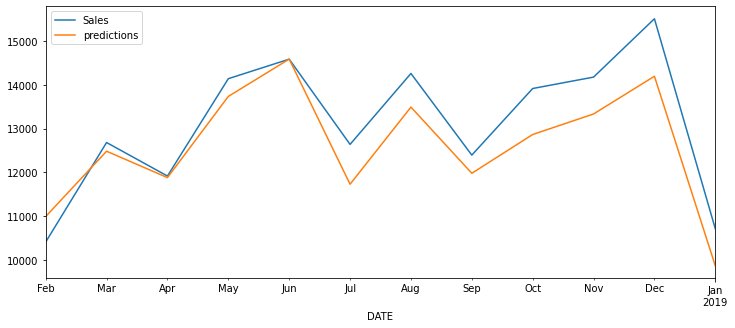

In [81]:
test.plot(figsize=(12,5))

**Step 8 : Saving and Loading Model**

In [82]:
model.save('SalesModel.h5')

In [84]:
from keras.models import load_model

In [85]:
model_new = load_model('SalesModel.h5')

In [86]:
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**Step 8 : Forecasting**

In [100]:
# holding the predictions
forecasting = []

# last n_inputs points from the training set
first_eval_batch = scaled_train[-n_input:]

# reshape this to the format RNN wants
current_batch = first_eval_batch.reshape((1,n_input,n_features))

# How far into the future will I forecast?
# len(test) 
for i in range(50):

    # Predict the next point
    current_pred = model.predict(current_batch)[0]    

    # Store the prediction
    forecasting.append(current_pred)

    # Update the current batch to include the prediction so we can predict the next value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [101]:
forecasting

[array([0.68083733], dtype=float32),
 array([0.8081042], dtype=float32),
 array([0.75662255], dtype=float32),
 array([0.9148378], dtype=float32),
 array([0.987533], dtype=float32),
 array([0.7437732], dtype=float32),
 array([0.89399755], dtype=float32),
 array([0.76511586], dtype=float32),
 array([0.8406359], dtype=float32),
 array([0.8806177], dtype=float32),
 array([0.95414], dtype=float32),
 array([0.5847378], dtype=float32),
 array([0.7170339], dtype=float32),
 array([0.8081251], dtype=float32),
 array([0.7867812], dtype=float32),
 array([0.9236345], dtype=float32),
 array([0.9770064], dtype=float32),
 array([0.7667042], dtype=float32),
 array([0.90022385], dtype=float32),
 array([0.7730125], dtype=float32),
 array([0.8522536], dtype=float32),
 array([0.88445246], dtype=float32),
 array([0.94873595], dtype=float32),
 array([0.6116922], dtype=float32),
 array([0.74546844], dtype=float32),
 array([0.80811155], dtype=float32),
 array([0.81275266], dtype=float32),
 array([0.9272605], d

In [102]:
true_forecasting = scaler.inverse_transform(forecasting)
true_forecasting

array([[10996.11596113],
       [12485.0112353 ],
       [11882.72724605],
       [13733.68716031],
       [14584.14825451],
       [11732.40292382],
       [13489.87733757],
       [11982.0904125 ],
       [12865.59934413],
       [13333.34621686],
       [14193.48394769],
       [ 9871.84726143],
       [11419.57986134],
       [12485.25529546],
       [12235.55316317],
       [13836.6003561 ],
       [14460.99759036],
       [12000.67245567],
       [13562.71883523],
       [12074.47345841],
       [13001.5150519 ],
       [13378.20935524],
       [14130.26190686],
       [10187.1869328 ],
       [11752.23525232],
       [12485.09700501],
       [12539.39341718],
       [13879.02080095],
       [14358.84934884],
       [12227.13239038],
       [13623.50236642],
       [12176.14892054],
       [13116.26028419],
       [13403.68853849],
       [14075.303743  ],
       [10492.00342745],
       [12015.79023921],
       [12486.31660849],
       [12793.02212876],
       [13880.943995  ],


In [103]:
df_f = pd.DataFrame(true_forecasting, columns=['sales_forecast'])
df_f.head()

,sales_forecast
0,10996.115961
1,12485.011235
2,11882.727246
3,13733.687160
4,14584.148255


<AxesSubplot:>

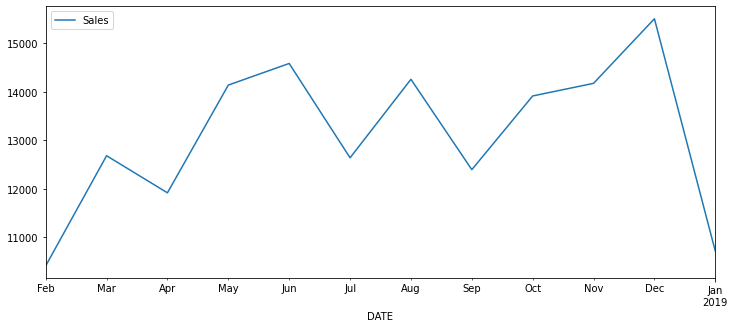

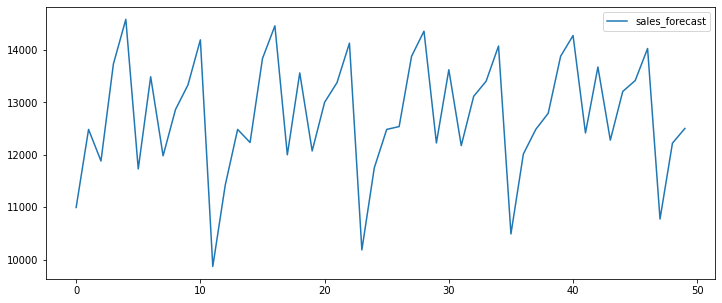

In [104]:
test[['Sales']].plot(figsize=(12,5))
df_f.plot(figsize=(12,5))